# Lab 7 - Email EDA with Clustering
---------------------------------------------------------------------------
Author: Kevin Paganini    
Date: 1/30/2023    
Description: This lab serves as a practice in applying clustering methods (specifically the DBscan method in this case) for exploratory data analysis on a dataset of 65,542 emails labeled as spam or ham. The dataset includes emails from the R programming language community as well as emails from a university. The emails are stored in JSON files with 5 features: spam/ham label, recipient email, sender email, subject, and body. First the data is read into a pandas dataframe. Then the body column of the dataframe is transformed into a continuous binary BOW array. The feature matrix is further condensed into 10 columns using SVD. The 2 most important columns are grouped using a clustering algorithm from SK-Learn. The resulting clusters are visualized and analyzed for the vocabulary using binomial tests. Finally, the data set entries are reviewed to gain more insights into what the clustering algorithm is grouping by.


#### Imports and Setup

In [29]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sys
import glob as gb
import json

pd.set_option('display.max_rows', 250)


# makes plots nice
def make_pretty(ax, title='', x_label='', y_label='', img=False):
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    if img:
        ax.axis('off')
    return ax


email_path = os.path.join('Data', 'email_json')




## Part 1 - Load and Transform the Data

In [30]:
def load_json_files(directory):
    json_files = gb.glob(directory + '/*.json')
    print(len(json_files))
    json_dicts = []
    for file in json_files:
        with open(file) as json_file:
            json_dicts.append(json.load(json_file))
    return json_dicts



def dicts_to_dataframe(json_dicts):
    return pd.DataFrame(json_dicts)

df = dicts_to_dataframe(load_json_files(email_path))

63542


In [31]:
df.head()

,category,to_address,from_address,subject,body
0,spam,the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",\n\n\n\n\n\n\nDo you feel the pressure to perf...
1,ham,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,Typo in /debian/README,"Hi, i've just updated from the gulus and I che..."
2,spam,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...",authentic viagra,authentic viagra\n\nMega authenticV I A G R A...
3,spam,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>",Nice talking with ya,"\nHey Billy, \n\nit was really fun going out t..."
4,spam,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",or trembling; stomach cramps; trouble in sleep...,"\n\n\n\n\n\n\nsystem"" of the home. It will ha..."


In [32]:
from sklearn.feature_extraction.text import CountVectorizer

# the count vectorizer is a BOW representation
# each column is a unique token
# each row is one body of an email
# each value is how many times the word appeared in the email
# since we used binary, it is just if the word appears or not



cv = CountVectorizer(binary=True, min_df=10)
feat_mat = cv.fit_transform(df['body'].values)
print(f'Shape of the feature matrix: {feat_mat.shape}')


Shape of the feature matrix: (63542, 32144)


## Part 2 - Cluster the emails

Part a: I will be using DBscan for my clustering algorithm, because I like dbscan. I like how it produces mostly consistent results and runs in $\Theta$(nlogn). I also like the idea behind it how it kind of just walks along the data points. DBscan can handle any kind of cluster so it is appropriate for the dataset.

Part B: 

Truncated SVD (similar PCA) to reduce dimensionality of the dataset.

In [33]:
from sklearn.decomposition import TruncatedSVD


tsvd = TruncatedSVD(n_components=10, random_state=42)

transform_feat_mat = tsvd.fit_transform(feat_mat)

Running DBscan on the SVD results

In [34]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=1.3, min_samples=100).fit(transform_feat_mat[:,0:2])
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)



Estimated number of clusters: 2
Estimated number of noise points: 48


(Why limit ourselves to two elements of the transform. We could have had 10) Clustered on fiorst 10 and then plot only the first two

In [35]:
def strings_r_better(x):
    if x == -1:
        return 'Noise'
    elif x == 0:
        return 'spam'
    else:
        return 'ham'
    

Plotting DBscan clusters

<AxesSubplot: title={'center': 'DBscan clustering'}, xlabel='SVD component 1', ylabel='SVD component 2'>

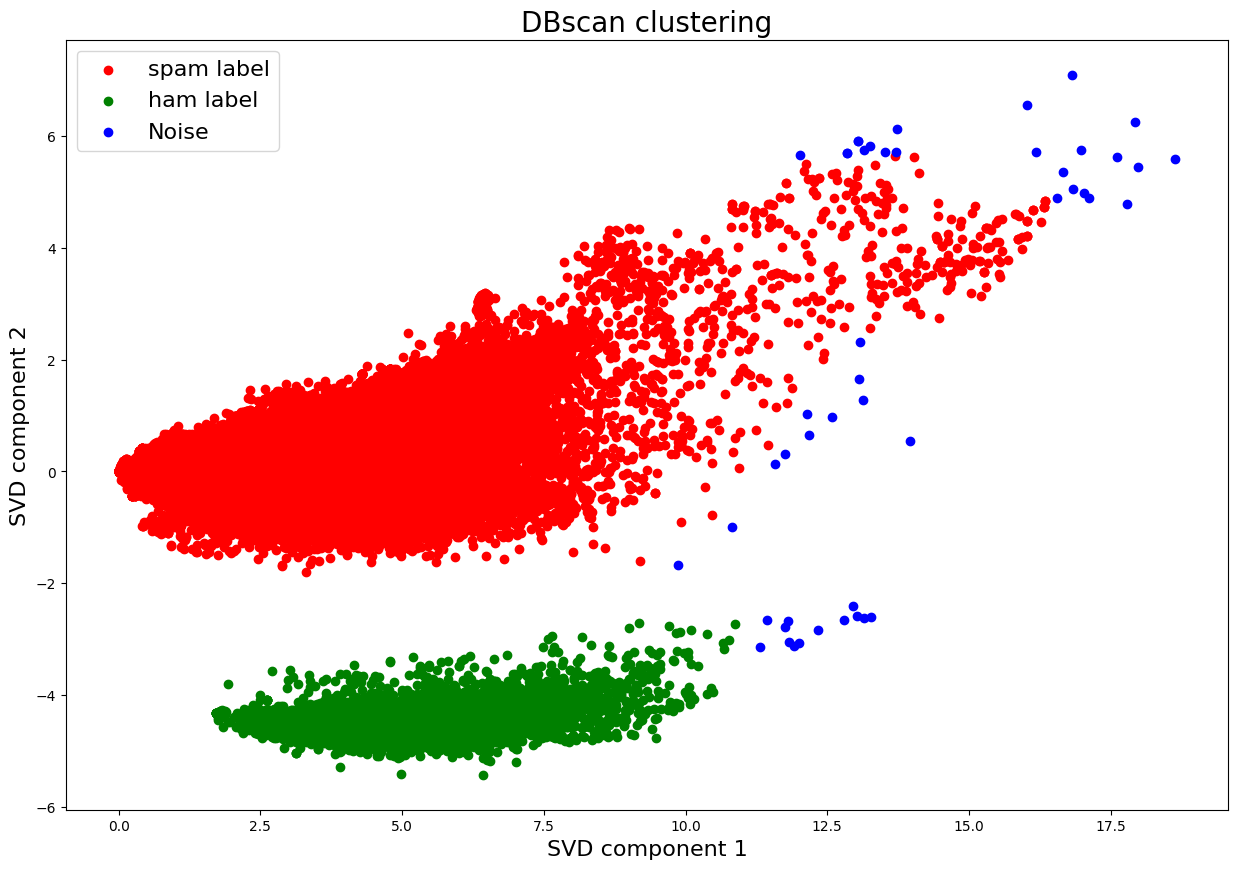

In [36]:
df_plot = pd.DataFrame(transform_feat_mat[:,0:2])
df_plot['labels'] = labels
df_plot['labels'] = df_plot['labels'].apply(strings_r_better)
plot_0 = df_plot[df_plot['labels'] == 'spam']
plot_1 = df_plot[df_plot['labels'] == 'ham']
plot_noise = df_plot[df_plot['labels'] == 'Noise']


fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(plot_0[0], plot_0[1], c='red', label='spam label')
ax.scatter(plot_1[0], plot_1[1], c='green', label='ham label')
ax.scatter(plot_noise[0], plot_noise[1],c='blue', label='Noise')
make_pretty(ax, 'DBscan clustering', 'SVD component 1', 'SVD component 2')


Part d: The cluster assignments look correct, according to the algorithm. DBscan starts at a random point and works its way through the dataset, assigning points that are surrounded by many points as main points and looking at their neighborhood. All points in the neighborhood are assigned to the same cluster as the main point. This is what looks like has happened here. The clusters that are far apart are assigned to different clusters. One can also see that it has labeled ~300 points as noise. These were in the upper right corner of the cluster in lab 6. These are labeled as noise to their distance (epsilon) from the rest of the cluster.

nieghborhood = circle around main point (radius = epsilon) 


### Part 3 - Calculating document frequencies of words

In [37]:
from scipy.sparse import csr_matrix, csc_matrix
import scipy.sparse as sparse




spam_labels = df_plot['labels']
# creating a csc matrix with only the spam labels
# feat_mat[(spam_labels=='spam')] is getting all the indices
# getting all rows where label is spam and converting to sparse matrix (column based)
cluster_0_df = csc_matrix(feat_mat[(spam_labels == 'spam').values])
num_emails_cluster_0 = cluster_0_df.shape[0]

# getting all rows where label is ham and converting to sparse matrix (column based)
cluster_1_df = csc_matrix(feat_mat[(spam_labels == 'ham').values])
num_emails_cluster_1 = cluster_1_df.shape[0]

Getting sums for each word

In [38]:
cluster_0_sums = cluster_0_df.sum(0)
cluster_1_sums = cluster_1_df.sum(0)


Finding document frequencies of the words "love", "work" and "different".


In [39]:
love_index = cv.vocabulary_.get('love')
works_index = cv.vocabulary_.get('works')
different_index = cv.vocabulary_.get('different')

print(f'Cluster 0 emails freq counts: ')
print(f'Love: {cluster_0_sums[:,love_index].item()}')
print(f'Works: {cluster_0_sums[:,works_index].item()}')
print(f'Different: {cluster_0_sums[:,different_index].item()}\n')

print(f'Cluster 1 emails freq counts: ')
print(f'Love: {cluster_1_sums[:,love_index].item()}')
print(f'Works: {cluster_1_sums[:,works_index].item()}')
print(f'Different: {cluster_1_sums[:,different_index].item()}')



Cluster 0 emails freq counts: 
Love: 2013
Works: 2361
Different: 2084

Cluster 1 emails freq counts: 
Love: 23
Works: 629
Different: 779


### Part 4 - Find enriched words with statistical testing

#### Love

In [40]:
from scipy import stats 

w_count = cluster_1_sums[0:,love_index]
cluster_1_expected_prob = w_count / num_emails_cluster_1
print(f'Expected probability for love in cluster 1: {cluster_1_expected_prob.item()}')

pvalue = stats.binom_test(cluster_0_sums[0:,love_index], num_emails_cluster_0, cluster_1_expected_prob, alternative='greater')
print(f'P-value for love: {pvalue.item()}')

Expected probability for love in cluster 1: 0.00397923875432526
P-value for love: 0.0


#### Works

In [41]:
w_count = cluster_1_sums[0:,works_index]
cluster_1_expected_prob = w_count / num_emails_cluster_1
print(f'Expected probability for works in cluster 1: {cluster_1_expected_prob.item()}')

pvalue = stats.binom_test(cluster_0_sums[0:,works_index], num_emails_cluster_0, cluster_1_expected_prob, alternative='greater')
print(f'P-value for works: {pvalue.item()}')

Expected probability for works in cluster 1: 0.10882352941176471
P-value for works: 1.0


### Going through each word in vocabulary and calculating the p value

In [42]:
def calc_p_val_cluster_0(idx):
    w_count = cluster_1_sums[0:,idx]
    cluster_1_expected_prob = w_count / num_emails_cluster_1
    # print(f'Expected probability for works in cluster 1: {cluster_1_expected_prob}')

    pvalue = stats.binom_test(cluster_0_sums[0:,idx], num_emails_cluster_0, cluster_1_expected_prob, alternative='greater')
    # print(f'P-value for works: {pvalue}')
    return pvalue, cluster_0_sums[0:,idx]

result_cluster_0 = []


for x in cv.vocabulary_:
    idx = cv.vocabulary_.get(x)
    pvalue, count = calc_p_val_cluster_0(idx)
    if pvalue < 0.05:
        result_cluster_0.append((pvalue.flatten()[0], x, count.item()))
    
    

In [43]:
result_cluster_0[0:10]

[(0.0, 'feel', 2136),
 (0.0, 'pressure', 764),
 (3.3880398001891204e-48, 'rising', 184),
 (3.7073695417194298e-28, 'occasion', 163),
 (0.0, 'viagra', 4675),
 (0.0, 'your', 25822),
 (2.5939355083110228e-54, 'anxiety', 235),
 (0.00486595851015862, 'will', 13804),
 (5.5774660085642466e-96, 'past', 1352),
 (7.2572476164895325e-155, 'back', 4066)]

Cleaning the result (removing non-alphabetic characters)

In [44]:


cleaned_result_cluster_0 = []

for tup in result_cluster_0:
    if tup[1].isalpha():
        cleaned_result_cluster_0.append(tup)
        
print(f'Number records removed: {len(result_cluster_0) - len(cleaned_result_cluster_0)}')  
      
    

Number records removed: 3674


#### Words enriched in cluster 0

In [45]:
sorted_cluster_0 = sorted(cleaned_result_cluster_0, key=lambda x: (x[0], -x[2]))
sorted_cluster_0[0:200]

[(0.0, 'your', 25822),
 (0.0, 'we', 17260),
 (0.0, 'here', 13594),
 (0.0, 'our', 13363),
 (0.0, 'up', 10839),
 (0.0, 'us', 9438),
 (0.0, 'day', 8349),
 (0.0, 'click', 7692),
 (0.0, 'their', 7410),
 (0.0, 'unsubscribe', 7367),
 (0.0, 'most', 7139),
 (0.0, 'price', 7066),
 (0.0, 'over', 6907),
 (0.0, 'who', 6846),
 (0.0, 'he', 6792),
 (0.0, 'online', 6776),
 (0.0, 'news', 5984),
 (0.0, 'buy', 5835),
 (0.0, 'free', 5574),
 (0.0, 'said', 5566),
 (0.0, 'his', 5538),
 (0.0, 'money', 5373),
 (0.0, 'visit', 5320),
 (0.0, 'high', 5256),
 (0.0, 'contact', 5233),
 (0.0, 'ca', 5221),
 (0.0, 'service', 5214),
 (0.0, 'life', 4831),
 (0.0, 'world', 4782),
 (0.0, 'site', 4706),
 (0.0, 'viagra', 4675),
 (0.0, 'quality', 4672),
 (0.0, 'low', 4404),
 (0.0, 'every', 4399),
 (0.0, 'net', 4189),
 (0.0, 'business', 4174),
 (0.0, 'men', 4122),
 (0.0, 'today', 4096),
 (0.0, 'home', 4067),
 (0.0, 'special', 4063),
 (0.0, 'her', 4001),
 (0.0, 'company', 3971),
 (0.0, 'week', 3955),
 (0.0, 'she', 3668),
 (0.0, 'g

Repeating for the other cluster

In [46]:
def calc_p_val_cluster_1(idx):
    w_count = cluster_0_sums[0:,idx]
    cluster_0_expected_prob = w_count / num_emails_cluster_0
    # print(f'Expected probability for works in cluster 1: {cluster_1_expected_prob}')

    pvalue = stats.binom_test(cluster_1_sums[0:,idx], num_emails_cluster_1, cluster_0_expected_prob, alternative='greater')
    # print(f'P-value for works: {pvalue}')
    return pvalue, cluster_1_sums[0:,idx]

result_cluster_1 = []


for x in cv.vocabulary_:
    idx = cv.vocabulary_.get(x)
    pvalue, count = calc_p_val_cluster_1(idx)
    if pvalue < 0.05:
        result_cluster_1.append((pvalue.flatten()[0], x, count.item()))

In [47]:
cleaned_result_cluster_1 = []

for tup in result_cluster_1:
    if tup[1].isalpha():
        cleaned_result_cluster_1.append(tup)
        
print(f'Number records removed: {len(result_cluster_1) - len(cleaned_result_cluster_1)}')  
      

Number records removed: 843


#### Cluster 1 enriched words: (bottom cluster)

In [48]:
sorted_cluster_1 = sorted(cleaned_result_cluster_1, key=lambda x: (x[0], -x[2]))
sorted_cluster_1[0:200]

[(0.0, 'do', 5780),
 (0.0, 'the', 5780),
 (0.0, 'self', 5780),
 (0.0, 'http', 5780),
 (0.0, 'org', 5780),
 (0.0, 'guide', 5780),
 (0.0, 'help', 5780),
 (0.0, 'www', 5780),
 (0.0, 'mailing', 5780),
 (0.0, 'stat', 5780),
 (0.0, 'math', 5780),
 (0.0, 'ethz', 5780),
 (0.0, 'ch', 5780),
 (0.0, 'mailman', 5780),
 (0.0, 'listinfo', 5780),
 (0.0, 'read', 5780),
 (0.0, 'posting', 5780),
 (0.0, 'project', 5780),
 (0.0, 'provide', 5780),
 (0.0, 'commented', 5780),
 (0.0, 'minimal', 5780),
 (0.0, 'contained', 5780),
 (0.0, 'reproducible', 5780),
 (0.0, 'code', 5780),
 (0.0, 'and', 5768),
 (0.0, 'list', 5723),
 (0.0, 'html', 5713),
 (0.0, 'please', 5709),
 (0.0, 'https', 5695),
 (0.0, 'to', 5385),
 (0.0, 'in', 4840),
 (0.0, 'of', 4742),
 (0.0, 'is', 4730),
 (0.0, 'this', 4090),
 (0.0, 'that', 3719),
 (0.0, 'but', 3399),
 (0.0, 'can', 3010),
 (0.0, 'wrote', 3005),
 (0.0, 'thanks', 2786),
 (0.0, 'there', 2495),
 (0.0, 'data', 2455),
 (0.0, 'am', 2212),
 (0.0, 'use', 2190),
 (0.0, 'using', 2181),
 (0.

## Reflection Questions


a. Make a guess as to why the emails might form two distinct clusters
- It almost seems as though the enriched variables in cluster 1 are academic emails. In the pvalue list we see words such as: guide, help, nonclinical, agingandhealth, row, columns, data, variables, math, professor, advance, statistics, plot, etc. It may be that the bottom cluster are serious emails between academia and the rest are personal emails / spam. It would also make sense that spam and personal emails have more similar word distributions. Then personal and academic emails.

b. Are spam messages in both clusters?
- No, spam messages are only in a single cluster. However they share this cluster with ham messages. Similar result as seen in the previous lab.

c. Skim through the top 200 words for each cluster. Can you identify any patterns for either of the clusters?
- As mentioned in (a), cluster 1 seems to contain serious academic emails. This is evidenced by the fact that their is a lot of talk about math and experiments. Cluster 0 on the other hand contains a lot more spammy words (it is after all the cluster with all the spam messages). You can see in there 'buy', 'click', 'money', 'price', 'pills' and 'pill'. I would imagine that these types of words would appear a lot in spam messages.  

d. Select the rows in the DataFrames for the emails in cluster 0.  Print the top 25.  Do the 
same for cluster 1.  Do you the to and from addresses and subject lines provide additional 
help in identifying patterns?

In [49]:

df[(df_plot['labels'] == 'ham').values].head(25)

,category,to_address,from_address,subject,body
8,ham,r-help@stat.math.ethz.ch,"""Jochen.F"" <jjfahr@ucalgary.ca>",[R] Confidence-Intervals.... help...,\nHi...\n\nI have to use R to find out the 90%...
16,ham,"""Jochen.F"" <jjfahr@ucalgary.ca>","""Sarah Goslee"" <sarah.goslee@gmail.com>",Re: [R] Confidence-Intervals.... help...,Hm... sounds like a homework problem to me...\...
24,ham,r-help@stat.math.ethz.ch,Michael Kubovy <kubovy@virginia.edu>,[R] Failure of mcsamp() but not mcmcsamp(),"Daer r-helpers,\n\nCan anyone help with the fo..."
68,ham,"""Wilfred Zegwaard"" <wilfred.zegwaard@gmail.com>","""Johann Hibschman"" <johannh@gmail.com>",Re: [R] Reasons to Use R,"On 4/6/07, Wilfred Zegwaard wrote:\n\n> I'm n..."
75,ham,"""Johann Hibschman"" <johannh@gmail.com>","""Gabor Grothendieck"" <ggrothendieck@gmail.com>",Re: [R] Reasons to Use R,"On 4/8/07, Johann Hibschman wrote:\n> R's pas..."
112,ham,r-help@stat.math.ethz.ch,"""Zia Uddin Ahmed"" <zua3@cornell.edu>",[R] How do I back transforme ordinary log-krig...,I have a question to everybody.\n\nAfter log10...
149,ham,<r-help@stat.math.ethz.ch>,"""Cressoni, Massimo \(NIH/NHLBI\) [F]"" <cresson...",[R] Plot symbols dimensions,\nI am writing some code to obtain publication...
278,ham,r-help@stat.math.ethz.ch,Wilfred Zegwaard <wilfred.zegwaard@gmail.com>,Re: [R] Reasons to Use R,"Dear Johann and Gabor,\n\nIt's what amounts to..."
307,ham,r-help@stat.math.ethz.ch,=?ISO-2022-JP?B?GyRCQG44fRsoQiAbJEI9JDwjGyhC?=...,[R] Could not fit correct values in discrimina...,"Dear R-users,\n\nI would like to use ""bruto"" f..."
318,ham,r-help@stat.math.ethz.ch,"""joey repice"" <fireseedmusic@gmail.com>",[R] R:Maximum likelihood estimation using BHHH...,"Dear R users,\n\nI am new to R. I would like t..."


In [50]:
df[(df_plot['labels'] == 'spam').values].head(25)

,category,to_address,from_address,subject,body
0,spam,the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",\n\n\n\n\n\n\nDo you feel the pressure to perf...
1,ham,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,Typo in /debian/README,"Hi, i've just updated from the gulus and I che..."
2,spam,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...",authentic viagra,authentic viagra\n\nMega authenticV I A G R A...
3,spam,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>",Nice talking with ya,"\nHey Billy, \n\nit was really fun going out t..."
4,spam,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",or trembling; stomach cramps; trouble in sleep...,"\n\n\n\n\n\n\nsystem"" of the home. It will ha..."
5,spam,manager@speedy.uwaterloo.ca,"""Bobby L. Fleming"" <zvyrepeated@liselebel.com>",Which is duty,\n\n\n\n\n\n\nthe program and the creative abi...
6,spam,"""Theorize"" <theorize@plg.uwaterloo.ca>","""Esteban Everett"" <dbmagyrln@dbmag.com>",Theorize get inside for local esc0rts who do i...,\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t...
7,spam,theorize@plg.uwaterloo.ca,Real Loss <fibond@terra.com.do>,Losing Weight Quickly,\n\n\n\n\n\n HoodiaLife - Start Losing Weight ...
9,spam,<smile@speedy.uwaterloo.ca>,"""Billy Chin"" <boxer@0733.com>",For Smile,\n\n\n\n\n\n\nGood day!\nVisit our new online ...
10,spam,ftp@plg.uwaterloo.ca,"""Josie Abernathy"" <cebcalhounrennerhog@calhoun...",Less weight - more pleasure and joy,\nCheck out the wonders of pound melting\n\n\n...


I think if you just looked at the extension of the to_address, you coul make a good predictor of spam vs. ham. '.ca' accounts tend to receive spam. Subject lines also appear click baity. Usually offering to buy something, or talk about pills or love. I think if I was making a predictor of spam vs. ham I would definitely include the to_ and from_adress as well as the subject line. 

e. The clusters represent email from two separate mailing lists.  One mailing list is for the R programming language, while the other mailing list is for a university. Which mailing list contained all of the spam?

Suprisingly enough, the university emails contained all the spam. I'm guessing they do not have a spam filter and that gmail and other public accounts come with a spam filter. Also, this shows that my guess in (a) was wrong. Since R is a programming language about statistics and is used for experiments it would make sense that there is a lot of math and experiment talk. I find it suprising that university emails had so much spam. That cluster when looking at the p values was over run by clickbaity words. 